## Primero de todo los imports

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

np.random.seed(100)


# Creamos un directiorio para la salida
import os
if not os.path.exists('output'):
    os.makedirs('output')



# Para hacer test y train
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Para ajustar los hiper-parámetros
from sklearn.model_selection import GridSearchCV

# Preproceso
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

# Función de error
from sklearn.metrics import mean_squared_error, r2_score

# Funciones

In [2]:
#Function to display score results from CV
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def apply_gridsearch(model,params,X_train_gs,y_train_gs):
    grid_search = GridSearchCV(model, param_grid=params, cv=5,
                               scoring='neg_root_mean_squared_error',
                               return_train_score=True,n_jobs=-1)
    grid_search.fit(X_train_gs, y_train_gs)

    print("Best trained model:")
    print(grid_search.best_estimator_)
    print("Best parameters:")
    print(grid_search.best_params_)
    print("Best Score")
    print(np.sqrt(-grid_search.best_score_),-grid_search.best_score_)
    return grid_search.best_estimator_
    
def create_att_dic(list_att):
    dic_att={}
    for key in initial_atr.keys():
        dic_att[key]=[]
    for (k,v) in list_att:
        dic_att[k].append(v)
    return dic_att



# Los datos

In [3]:
# Cargamos el dataset
housing = pd.read_csv('dataset/housing-snapshot/train_set.csv',index_col=0) 
print("Número de casas:",housing.shape[0]," Número de características:", housing.shape[1])
housing_num = housing.select_dtypes(exclude=[np.object]).columns
housing_cat = housing.select_dtypes(include=[np.object]).columns
print("\n Características numéricas: \n ", list(housing_num))
print("Características categóricas: \n", list(housing_cat))

housing.head()

Número de casas: 5432  Número de características: 21

 Características numéricas: 
  ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
Características categóricas: 
 ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,...,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,...,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,...,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0
3,Brunswick,13 Percy St,3,h,1055000.0,S,Nelson,7/05/2016,5.2,3056.0,...,1.0,1.0,324.0,NaN,1930.0,Moreland,-37.76530,144.95860,Northern Metropolitan,11918.0
4,Templestowe Lower,253 Thompsons Rd,4,h,1000000.0,VB,hockingstuart,13/08/2016,13.8,3107.0,...,3.0,2.0,728.0,164.0,1970.0,Manningham,-37.76800,145.10270,Eastern Metropolitan,5420.0


In [4]:

# Ponemos "Postcode" a categorical, dado que que no es numérica.
housing['Postcode'] = pd.Categorical(housing.Postcode)

# Dividimos haciendo uso de la estratificación para tener una buena proporción.
housing["price_aux"] = pd.cut(housing["Price"],
                               bins=[0., 500000, 1000000, 1500000, 2000000., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["price_aux"]):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

# Quitamos la etiqueta price_cat
train_set.drop("price_aux", axis=1, inplace=True)
test_set.drop("price_aux", axis=1, inplace=True)
housing.drop("price_aux", axis=1, inplace=True)

# El con el train probaremos los modelos.
X_train = train_set.drop("Price", axis=1).copy()
y_train = train_set["Price"].copy()
# El test no lo tenemos que tocar hasta el final de todo.
X_test = test_set.drop("Price", axis=1).copy()
y_test = test_set["Price"].copy()


housing_num = X_train.select_dtypes(exclude=[np.object]).columns
housing_cat = X_train.select_dtypes(include=[np.object]).columns

## Las funciones de las pipelines

In [5]:
# Reemplaza 0 por NaN's
def replace_0_2_NaN(data):
    data[data == 0] = np.nan
    return data


# Los índices de las columnas 
Rooms_ix, Bedroom2_ix, Bathroom_ix, BuildingArea_ix = 0, 2, 3, 6
# Para combinar atributos
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_building_area = X[:, Rooms_ix] / (1.0 +X[:, BuildingArea_ix])# add 1 to avoid 0 division
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, Bedroom2_ix] / (1.0 + X[:, Bathroom_ix]) # add 1 to avoid 0 division
            return np.c_[X, rooms_per_building_area, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_building_area]

# Divide un atributo por otro
class DividedAtributes(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        proportion1 = X[:, 0] / (1.0 +X[:, 1])# add 1 to avoid 0 division
        proportion2 = np.ones(proportion1.shape, dtype=np.float)/proportion1
        return np.c_[proportion1,proportion1]

# Invierte una variable
class invert_variable(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        data=np.zeros(X.shape,dtype=np.float)
        for i in range(X.shape[1]):
            data[:, 0]=1/X[:, 0]
        return np.c_[X,data]
# Convierte las categóricas a la media del precio de los valores
class Categorical_2_mean(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.medias_por_columnas=[]
        self.media_y=0
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        self.media_y = y.mean()
        self.medias_por_columnas=[]
        #Para cada columna
        for i in range(X.shape[1]):
            medias = {}
            columna = X[:,i]
            unicos = np.unique(columna)
            #Para cada valor guardo la media
            for u in unicos:
                medias[u]=y[columna==u].mean()
                
            self.medias_por_columnas.append(medias)
            
        return self  # nothing else to do
    
    def transform(self, X):
        data = np.ones((X.shape[0]))
        
        for i in range(X.shape[1]):
            columna = X[:,i]
            media = self.medias_por_columnas[i]
            nueva_columna = np.zeros(X.shape[0])+self.media_y
            
            #Para cada valor distinto dentro de la categoría
            for k in media.keys():
                nueva_columna[columna == k] = media[k]
            
            #Si es la primera vez
            if i == 0:
                data = nueva_columna
            else:
                data = np.c_[data,nueva_columna]
        return data

class Clean_Outlayers_Quantile(BaseEstimator, TransformerMixin):
    def __init__(self,q=0.01): # no *args or **kargs
        self.q=q
        self.low_q_col=[]
        self.high_q_col=[]
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        #Para cada columna
        for i in range(X.shape[1]):
            columna = X[:,i]
            self.high_q_col.append(np.quantile(a=columna , q=1-self.q))
            self.low_q_col.append(np.quantile(a=columna ,q=self.q))
        return self  # nothing else to do
    
    def transform(self, X):
        for i in range(X.shape[1]):
            q_high=self.high_q_col[i]
            q_low =self.low_q_col[i]
            columna = X[:,i]
            columna[columna>q_high]=q_high
            columna[columna<q_low]=q_low
        return X    

# Ejemplo de PipeLines
"""
1.Para las columnas con muchos ceros sin sentido. 
Además se les aplicará la función logaritmo.
Las columnas que tienen sentido en esta pipe son "BuildingArea" y "Landsize" 
"""
num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
])

# 2.Para las otras columnas numéricas
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
])



"""
Para las variables categóricas. Principalmente utilizaremos el OneHotEncoder
Esta pipe convierte columnas categóricas en numéricas creando una columna de 
1's y 0's por cada valor único en la columna original.

Ejemplo:
Original "Type":
Type
h
t
h
u
h

Dummies from "Type":
h t u
1 0 0
0 1 0
1 0 0
0 0 1
1 0 0

Esto sube muchísimo la dimensionalidad si la columna original
tiene muchos valores distintos, así que hay que tratarlo con cuidado.

"""
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']
# Esta es una especie de Pipeline madre que coge otras pipelines y procesa
# todo el data set. Cada pipeline se aplica a las columnas de la lista
# num0_pipeline con las columnas en la lista num_attribs0
full_pipeline_ejemplo = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
])


# Los modelos

Vamos a tratar unos modelos de machine learning y en concreto haremos uso de la famosa librería Sklearn. En cada uno de los distintos modelos vamos a mostrar primero una implementación naíf y luego vamos a hacer un preproceso de datos personalizado, una feature selection y cuando sea posible una optimización de los hiper-parámetros para conseguir los mejores resultados posibles.

In [6]:
# KNN
from sklearn import neighbors    
# Linear Regression
from sklearn.linear_model import LinearRegression
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Implementación naíf

In [7]:


#Para las otras columnas numéricas
num_naif_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value=0.)),
    ])
#Para las variables categóricas. Principalmente utilizaremos el OneHotEncoder
cat_naif_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])
"""
Columnas numéricas:  ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Columnas categóricas:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""

#Estas son las columnas seleccionadas en el proyecto base para cada pipeline.
num_attribs = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']

#Creamos la "full_pipeline", es decir la pipeline que engloba a todas las otras.
full_naif_pipeline = ColumnTransformer([
        ("num", num_naif_pipeline, num_attribs),
        ("cat", cat_naif_pipeline, cat_attribs),
])
#Preprocesamos los datos utilizando la "full_pipeline"
housing_prepared = full_naif_pipeline.fit_transform(X_train,y_train)

forest_reg = RandomForestRegressor(random_state=42, max_depth = 5)
forest_reg.fit(housing_prepared, y_train)

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, y_train)


n_neighbors = 3
knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
knn_reg.fit(housing_prepared, y_train)

models = [(lin_reg,"lin_reg"),
          (knn_reg,"KNN-Regressor"),
          (forest_reg,'Random Forest')
]


for model in models:
    scores = cross_val_score(model[0], housing_prepared, y_train, scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 384161.00287804304
Standard deviation: 42269.01992080505
---- KNN-Regressor ----
Mean: 522306.63215915824
Standard deviation: 38406.96738846908
---- Random Forest ----
Mean: 371960.5115135976
Standard deviation: 44246.185857132376


Tarda mucho en ejecutarse (Si quieres ejecutarlo simplemente descomenta el for que está justo al final de la celda anterior.), así que aquí pongo los resultados:    

    ---- lin_reg ----
        Mean: 384161.00287804304
        Standard deviation: 42269.01992080505
    ---- KNN-Regressor ----
        Mean: 522306.63215915824
        Standard deviation: 38406.96738846908
    ---- Random Forest ----
        Mean: 371960.5115135976
        Standard deviation: 44246.185857132376
        
Estos serán nuestros resultados base, nuestro punto de referencia.

# 1. KNN

In [8]:
# Primero el preprocesamiento
rf_pipe_num0 = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ('log',FunctionTransformer(np.log1p, validate=True)),
    ("std",StandardScaler()),
])

rf_pipe_num1 = Pipeline([
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ("std",StandardScaler()),
])

rf_pipe_poli = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ('zeros2NaN_2',FunctionTransformer(func = replace_0_2_NaN,validate=False)),# por si acaso hay algun 0
    ("invert_1/var",invert_variable()),
    ("poly_interact_2",PolynomialFeatures(interaction_only=True,degree=2)),
    ("std",StandardScaler()),
])

rf_cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])

#cat2mean = Categorical_2_mean(minim_instances=10)
rf_cat2mean_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('cat2mean', Categorical_2_mean()),
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ("std",StandardScaler()),
])

In [9]:
X_train_knn = X_train.copy()
y_train_knn = y_train.copy()



num_pipe_log  = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ("clean_outlayer",Clean_Outlayers_Quantile()),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
])

num_pipe      = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ("clean_outlayer",Clean_Outlayers_Quantile()),
        ('std_scaler', StandardScaler()),
])

cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])

# Características seleccionadas:
num_features = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
log_features = ['Landsize','BuildingArea']
cat_features = ['Type']

num_poli_att = ['Rooms','BuildingArea','Bathroom']

initial_atr = {'num_log_att': ['Landsize', 'BuildingArea'], 
               'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 
                           'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 
               'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 
               'cat_att': ['Type']}

full_pipe_knn = ColumnTransformer([
            ("num0", rf_pipe_num0, initial_atr["num_log_att"]),
            ("num1", rf_pipe_num1, initial_atr["num_att"]),
            ("poli", rf_pipe_poli, initial_atr["num_poli_att"]),
            ("cat",  rf_cat_pipe, initial_atr["cat_att"]),

])

"""        ("num_log", num_pipe_log, log_features),
        ("num", num_pipe, num_features),
        ("poli", rf_pipe_poli, num_poli_att),
        ("cat", cat_pipe, cat_features),"""

X_train_knn_prepared=full_pipe_knn.fit_transform(X_train_knn,y_train_knn)
print("Dataset original:",X_train_knn.shape)
print("Dataset procesado:",X_train_knn_prepared.shape)

Dataset original: (4345, 20)
Dataset procesado: (4345, 36)


In [10]:

scores = cross_val_score(knn_reg, X_train_knn_prepared, y_train_knn, scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1)
display_scores(-scores, knn_reg)

---- KNeighborsRegressor(n_neighbors=3) ----
Mean: 410423.7867249962
Standard deviation: 22385.20610384715


Vemos una mejora sustancial solo con un preproceso simple:

    ---- KNN-Regressor NAIF----
        Mean: 522306.63215915824
        Standard deviation: 38406.96738846908

    ---- KNeighborsRegressor Preprocesado ----
        Mean: 410423.7867249962
        Standard deviation: 22385.20610384715

Aún lo podemos mejorar más haciendo uso de un algoritmo de feature selection:

In [11]:

"""
NUMERICAL:    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
CATEGORICAL:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""
num_log_att = ['Landsize','BuildingArea']
num_att = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

num_poli_att = ['Rooms','BuildingArea','Bathroom']

cat_att = ['Type']#,"CouncilArea",'Suburb','Regionname','Postcode']

initial_atr = {
    "num_log_att":num_log_att.copy() ,
    "num_att":num_att.copy() ,
    "num_poli_att":num_poli_att.copy() ,
    "cat_att":cat_att.copy() ,
}

{'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 'cat_att': ['Type']}
initial_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, initial_atr["num_log_att"]),
            ("num1", rf_pipe_num1, initial_atr["num_att"]),
            ("poli", rf_pipe_poli, initial_atr["num_poli_att"]),
            ("cat",  rf_cat_pipe, initial_atr["cat_att"]),
])

model = neighbors.KNeighborsRegressor(5)

start = time.time()

X_train_initial = initial_full_pipe.fit_transform(X_train,y_train)
previous_score_winner = -cross_val_score(model, X_train_initial, y_train,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()

actual_list_atts = []    
for k in initial_atr.keys():
    for v in initial_atr[k]:
        actual_list_atts.append((k,v))

initial_score = 10000000
buscando = True

cont=0
while buscando and len(actual_list_atts)!=0:
    
    end = time.time()
    tiempo=end - start
    start = end
    cont+=1
    dic_=create_att_dic(actual_list_atts)
    print(cont,". Score: ",previous_score_winner)
    print("-Tiempo (s) :" ,tiempo )
    print("-Num atributos:", len(dic_))
    print("-Atributos: ", dic_)

    scores_ronda=[]
    for at in actual_list_atts:
        actual_list_without_at = actual_list_atts.copy()
        actual_list_without_at.remove(at)
        #Aqui hemos quitado la feature
        dict_att=create_att_dic(actual_list_without_at)
        #Creamos la nueva pipe sin dicho atributo
        actual_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, dict_att["num_log_att"]),
            ("num1", rf_pipe_num1, dict_att["num_att"]),
            ("poli", rf_pipe_poli, dict_att["num_poli_att"]),
            ("cat",  rf_cat_pipe, dict_att["cat_att"]),
        ])
        #Procesamos los datos con la nueva pipe
        X_train_actual = actual_full_pipe.fit_transform(X_train,y_train)
        #Calculamos con el modelo y guardamos como de bueno es
        actual_score = - cross_val_score(model, X_train_actual, y_train,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()
        scores_ronda.append((actual_score,at))
    
    winner = min(scores_ronda, key= lambda x : x[0])
    #Aquí tenemos el mejor score y el atributo que hay que quitar para tenerlo
    score_winner, att_winner = winner
    
    #Si este resultado es mejor que el mejor de la ronda anterior
    if score_winner < previous_score_winner:
        actual_list_atts.remove(att_winner)
        previous_score_winner = score_winner
        
    #Si no es mejor hemos acabado
    else:
        buscando=False
    
final_att = create_att_dic(actual_list_atts)
print()
print("Resultado final: ")
print("Score: ", previous_score_winner)
print("Atributos resultantes:",final_att)

1 . Score:  390518.7688796599
-Tiempo (s) : 0.38369059562683105
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 'cat_att': ['Type']}
2 . Score:  375655.19698735856
-Tiempo (s) : 4.963524103164673
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea'], 'cat_att': ['Type']}
3 . Score:  368151.43482465885
-Tiempo (s) : 2.4353580474853516
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea'], 'cat_att': ['Type']}
4 . Score:  365

In [12]:
# Estos son los atributos que nos interesan
final_atr_knn = {'num_log_att': ['Landsize'], 
                 'num_att': ['Rooms', 'Distance', 'Lattitude', 'Longtitude'], 
                 'num_poli_att': [], 
                 'cat_att': ['Type'], 
                 'cat2mean_att': []
                }

final_full_pipe_knn = ColumnTransformer([
            ("num0", rf_pipe_num0, final_atr_knn["num_log_att"]),
            ("num1", rf_pipe_num1, final_atr_knn["num_att"]),
            ("poli", rf_pipe_poli, final_atr_knn["num_poli_att"]),
            ("cat",  rf_cat_pipe, final_atr_knn["cat_att"]),
])
model = neighbors.KNeighborsRegressor(5)

X_train_knn_prepared=final_full_pipe_knn.fit_transform(X_train_knn,y_train_knn)
scores = cross_val_score(model, X_train_knn_prepared, y_train_knn, scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1)
display_scores(-scores, model)

---- KNeighborsRegressor() ----
Mean: 339237.6362330982
Standard deviation: 37377.58528653363


Creemos que estos resultados se pueden mejorar un poco más haciendo uso de la función GridSearch CV.

In [13]:
knn_param_grid={ "n_neighbors": range(1,20,1)
    
}

best_knn_model=apply_gridsearch(model=model,
                 params=knn_param_grid,
                 X_train_gs=X_train_knn_prepared,
                 y_train_gs=y_train_knn)

Best trained model:
KNeighborsRegressor(n_neighbors=7)
Best parameters:
{'n_neighbors': 7}
Best Score
579.2867896734388 335573.1846901588


----- KNN: EVALUATION ON TEST SET ------
RMSE 328799.51964722417
R^2:  0.7538839146506257


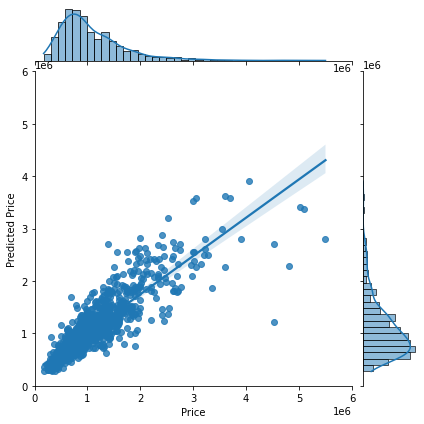

In [36]:
model = best_knn_model

X_train_prepared = final_full_pipe_knn.fit_transform(X_train_knn,y_train_knn)
X_test_prepared  = final_full_pipe_knn.transform(X_test)
## fit the model
model.fit(X_train_prepared, y_train_knn)

## predict training set
y_pred = model.predict(X_test_prepared)

## Evaluate the model and plot it
from sklearn.metrics import mean_squared_error, r2_score
print("----- KNN: EVALUATION ON TEST SET ------")
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE",rmse)
r2=r2_score(y_test, y_pred)
print("R^2: ",r2)

result = pd.DataFrame({"Price":y_test,
                      "Predicted Price":y_pred})

sns.jointplot(data=result, x="Price", y="Predicted Price",xlim=(0,6000000),ylim=(0,6000000),kind="reg")

# 2. Regresión Lineal

In [15]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()



In [16]:
# Primero el preprocesamiento
lr_pipe_num0 = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ('log',FunctionTransformer(np.log1p, validate=True)),
    ("std",StandardScaler()),
])

lr_pipe_num1 = Pipeline([
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ("std",StandardScaler()),
])

lr_pipe_poli = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ('zeros2NaN_2',FunctionTransformer(func = replace_0_2_NaN,validate=False)),# por si acaso hay algun 0
    #("divided",DividedAtributes()),
    ("invert_1/var",invert_variable()),
    ("poly_interact_2",PolynomialFeatures(interaction_only=True,degree=2)),
    ("std",StandardScaler()),
])

lr_cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])

#cat2mean = Categorical_2_mean(minim_instances=10)
lr_cat2mean_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('cat2mean', Categorical_2_mean()),
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ("std",StandardScaler()),
])

In [17]:
"""
NUMERICAL:    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
CATEGORICAL:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""
num_log_att = ['Landsize','BuildingArea']
num_att = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
num_poli_att = ['Rooms','BuildingArea','Bathroom']

cat_att = ['Type',"CouncilArea",'Suburb','Regionname','Postcode']
cat2mean_att = ['Type',"CouncilArea",'Suburb','Regionname','Postcode']

initial_atr = {
    "num_log_att":num_log_att.copy() ,
    "num_att":num_att.copy() ,
    "num_poli_att":num_poli_att.copy() ,
    "cat_att":cat_att.copy() ,
    #"cat2mean_att":cat2mean_att.copy() ,
}
"""
# !!!!!!!!!!!!!!!!!!!!!!!!! Descomentar esto si no se quiere esperar a que se ejecute toda la feature selection.
initial_atr = {
                'num_log_att': ['Landsize', 'BuildingArea'], 
                'num_att': ['Rooms', 'Distance', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude'], 
                'num_poli_att': ['Rooms', 'BuildingArea'], 'cat_att': ['Type', 'Regionname', 'Postcode'], 
                #'cat2mean_att': ['Type', 'CouncilArea', 'Suburb', 'Regionname', 'Postcode']
}

"""
initial_full_pipe = ColumnTransformer([
            ("num0", lr_pipe_num0, initial_atr["num_log_att"]),
            ("num1", lr_pipe_num1, initial_atr["num_att"]),
            ("poli", lr_pipe_poli, initial_atr["num_poli_att"]),
            ("cat",  lr_cat_pipe, initial_atr["cat_att"]),
            #("cat_2_mean",lr_cat2mean_pipe, initial_atr["cat2mean_att"])
])

model = LinearRegression()

start = time.time()

X_train_initial = initial_full_pipe.fit_transform(X_train_lr,y_train_lr)
previous_score_winner = -cross_val_score(model, X_train_initial, y_train_lr,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()

actual_list_atts = []    
for k in initial_atr.keys():
    for v in initial_atr[k]:
        actual_list_atts.append((k,v))


def create_att_dic(list_att):
    dic_att={}
    for key in initial_atr.keys():
        dic_att[key]=[]
    for (k,v) in list_att:
        dic_att[k].append(v)
    return dic_att
        

buscando = True
cont=0
while buscando and len(actual_list_atts)!=0:
    
    end = time.time()
    tiempo=end - start
    start = end
    cont+=1
    dic_=create_att_dic(actual_list_atts)
    print(cont,". Score: ",previous_score_winner)
    print("-Tiempo (s) :" ,tiempo )
    print("-Num atributos:", len(dic_))
    print("-Atributos: ", dic_)

    scores_ronda=[]
    for at in actual_list_atts:
        actual_list_without_at = actual_list_atts.copy()
        actual_list_without_at.remove(at)
        #Aqui hemos quitado la feature
        dict_att=create_att_dic(actual_list_without_at)
        #Creamos la nueva pipe sin dicho atributo
        actual_full_pipe = ColumnTransformer([
            ("num0", lr_pipe_num0, dict_att["num_log_att"]),
            ("num1", lr_pipe_num1, dict_att["num_att"]),
            ("poli", lr_pipe_poli, dict_att["num_poli_att"]),
            ("cat",  lr_cat_pipe, dict_att["cat_att"]),
            #("cat_2_mean",lr_cat2mean_pipe, dict_att["cat2mean_att"])
        ])
        #Procesamos los datos con la nueva pipe
        X_train_actual = actual_full_pipe.fit_transform(X_train_lr,y_train_lr)
        X_test_lr  = X_train_lr
        y_test_lr = y_train_lr
        #Calculamos con el modelo y guardamos como de bueno es
        actual_score = - cross_val_score(model, X_train_actual, y_train_lr,scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1).mean()
        scores_ronda.append((actual_score,at))
    
    winner = min(scores_ronda, key= lambda x : x[0])
    #Aquí tenemos el mejor score y el atributo que hay que quitar para tenerlo
    score_winner, att_winner = winner
    
    #Si este resultado es mejor que el mejor de la ronda anterior
    if score_winner < previous_score_winner:
        actual_list_atts.remove(att_winner)
        previous_score_winner = score_winner
        
    #Si no es mejor hemos acabado
    else:
        buscando=False
    
final_att = create_att_dic(actual_list_atts)
print()
print("Resultado final: ")
print("Score: ", previous_score_winner)
print("Atributos resultantes:",final_att)

1 . Score:  368990.72592813266
-Tiempo (s) : 0.3488163948059082
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 'cat_att': ['Type', 'CouncilArea', 'Suburb', 'Regionname', 'Postcode']}
2 . Score:  367745.91613541485
-Tiempo (s) : 6.3124425411224365
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], 'num_poli_att': ['Rooms', 'BuildingArea'], 'cat_att': ['Type', 'CouncilArea', 'Suburb', 'Regionname', 'Postcode']}
3 . Score:  367090.1441544214
-Tiempo (s) : 5.1910560131073
-Num atributos: 4
-Atributos:  {'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Long

In [18]:
atr_final_lr = {'num_log_att': ['Landsize', 'BuildingArea'], 
                'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude'], 
                'num_poli_att': ['Rooms', 'BuildingArea'], 
                'cat_att': ['Type', 'Suburb', 'Regionname']
               }
final_full_pipe_lr = ColumnTransformer([
            ("num0", lr_pipe_num0, dict_att["num_log_att"]),
            ("num1", lr_pipe_num1, dict_att["num_att"]),
            ("poli", lr_pipe_poli, dict_att["num_poli_att"]),
            ("cat",  lr_cat_pipe, dict_att["cat_att"]),
        ])

In [19]:

linear_regressor = LinearRegression()
# Preparamos los datos con la pipe final
X_train_prepared = final_full_pipe_lr.fit_transform(X_train_lr,y_train_lr)
# Ejecutamos el modelo
final_score = cross_val_score(linear_regressor, X_train_prepared, y_train_lr,scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
display_scores(-final_score, "Linear Regresor")

---- Linear Regresor ----
Mean: 368141.14236344805
Standard deviation: 37403.53473940317


----- LINEAR REGRESSOR: EVALUATION ON TEST SET ------
RMSE 346908.0673606226
R^2:  0.7088899253285588


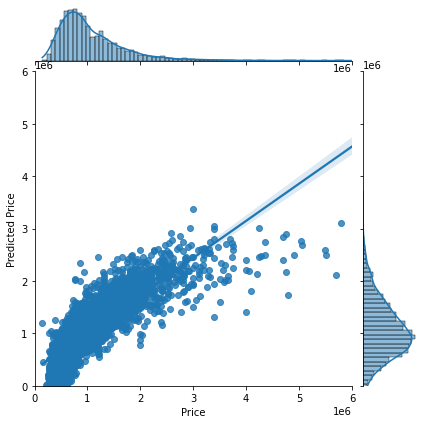

In [37]:
linear_regressor = LinearRegression()

# Preparamos los datos con la pipe final
X_train_prepared = final_full_pipe_lr.fit_transform(X_train_lr,y_train_lr)
X_test_prepared  = final_full_pipe_lr.transform(X_test_lr)

linear_regressor.fit(X_train_prepared,y_train_lr)
y_pred = linear_regressor.predict(X_test_prepared)
print("----- LINEAR REGRESSOR: EVALUATION ON TEST SET ------")
rmse=np.sqrt(mean_squared_error(y_test_lr, y_pred))
print("RMSE",rmse)
r2=r2_score(y_test_lr, y_pred)
print("R^2: ",r2)

result = pd.DataFrame({"Price":y_test_lr,
                      "Predicted Price":y_pred})

# I prefer this plot.
sns.jointplot(data=result, x="Price", y="Predicted Price",xlim=(0,6000000),ylim=(0,6000000),kind="reg")

# 3. Random Forest

In [21]:
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
model = RandomForestRegressor(random_state=100)

In [22]:
# Esta será la pipeline para el modelo Random Forest

#Para las columnas con muchos ceros sin sentido. A las que además se les aplicará la función logaritmo
num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])
#Para las otras columnas numéricas
num1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
#Para las variables categóricas. Principalmente utilizaremos el OneHotEncoder
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

"""
Columnas numéricas:  ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Columnas categóricas:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""

#Estas son las columnas seleccionadas por mi para cada pipeline.
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = ['Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']

#Creamos la "full_pipeline", es decir la pipeline que engloba a todas las otras.
full_pipeline_rf = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num1_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
])

#Preprocesamos los datos utilizando la "full_pipeline"
X_train_prepared = full_pipeline_rf.fit_transform(X_train_rf,y_train_rf)
print("Prepared: ",X_train_prepared.shape)

Prepared:  (4345, 516)


In [24]:
"""
Aquí tenemos todos los posibles atributos:
NUMERICAL:    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
CATEGORICAL:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""
# Aquí van los distintos atributos que entrarán a las pipelines en un principio.
# No tienen porqué estar todos los numéricos ni todos los categóricos en cada lista.

num_log_att = ['Landsize','BuildingArea']

num_att = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

num_poli_att = ['Rooms','BuildingArea','Bathroom']

cat_att =['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

initial_atr = {
    "num_log_att":num_log_att.copy() ,
    "num_att":num_att.copy() ,
    "num_poli_att":num_poli_att.copy() ,
    "cat_att":cat_att.copy() ,
}

# Comentar esto si se quiere ver la ejecución.
# La cosa es que tarda muchisimo en ejecutarse.
initial_atr = {'num_log_att': ['Landsize', 'BuildingArea'], 
               'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 
                           'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude'], 
               'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 
               'cat_att': ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
              }

initial_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, initial_atr["num_log_att"]),
            ("num1", rf_pipe_num1, initial_atr["num_att"]),
            ("poli", rf_pipe_poli, initial_atr["num_poli_att"]),
            ("cat",  rf_cat_pipe, initial_atr["cat_att"])
])

# Modelo: Este será el modelo con el que se calcule el la feature selection.
# Deberíamos probarlos todos para ver si consiguen una mejora notable con un preprocesamiento de datos más adaptado.
# Aquí muchos de los modelos están con parámetros bastante "baratos" para que se ejecute todo más rápido,
# aún así se pueden tocar todos los parámetros de los diferentes modelos, pero esto implica tiempos muy largos de cálculo.


model = RandomForestRegressor(max_depth=10,n_estimators = 20  , random_state=42)
#model = LinearRegression()

#En caso de utilizar el KNN no podemos tener en cuenta la pipeline de categorías con OneHotEncoder, 
#pues sube demasiado la dimensionalidad. Por ello ponemos la lista vacía.
#model = neighbors.KNeighborsRegressor(3)
#cat_att =[]

start = time.time()

# Calculamos primero con todos los atributos.
X_train_initial = initial_full_pipe.fit_transform(X_train,y_train)

previous_score_winner = -cross_val_score(model, X_train_initial, y_train,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()
# Creamos una lista de tuplas (nombre_pipeline, nombre_columna) para un manejo más sencillo en el bucle.
# Cada tupla representa un atributo de entrada a la pipeline.
actual_list_atts = []    
for k in initial_atr.keys():
    for v in initial_atr[k]:
        actual_list_atts.append((k,v))

buscando = True
cont=0
print(model)
while buscando and len(actual_list_atts)!=0:
    
    end = time.time()
    tiempo=end - start
    start = end
    if cont == 0:
        print("El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos")
    dic_=create_att_dic(actual_list_atts)
    print(cont,". Score: ",previous_score_winner)
    print()
    print("Tiempo(seg) cálculo:" ,tiempo )
    print()
    print(len(actual_list_atts)," atributos: ")
    for k in dic_.keys():
        print("  -",k,dic_[k])
    print("-------------------------------------------------------------------------------------------")

    scores_ronda=[]
    for at in actual_list_atts:
        actual_list_without_at = actual_list_atts.copy()
        actual_list_without_at.remove(at)
        #Aqui hemos quitado la feature
        dict_att=create_att_dic(actual_list_without_at)
        #Creamos la nueva pipe sin dicho atributo
        actual_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, dict_att["num_log_att"]),
            ("num1", rf_pipe_num1, dict_att["num_att"]),
            ("poli", rf_pipe_poli, dict_att["num_poli_att"]),
            ("cat",  rf_cat_pipe, dict_att["cat_att"])
        ])
        #Procesamos los datos con la nueva pipe
        X_train_actual = actual_full_pipe.fit_transform(X_train,y_train)
        #Calculamos con el modelo y guardamos como de bueno es
        actual_score = - cross_val_score(model, X_train_actual, y_train,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()
        scores_ronda.append((actual_score,at))
    
    winner = min(scores_ronda, key= lambda x : x[0])
    #Aquí tenemos el mejor score y el atributo que hay que quitar para tenerlo
    score_winner, att_winner = winner
    
    #Si este resultado es mejor que el mejor de la ronda anterior
    if score_winner < previous_score_winner:
        actual_list_atts.remove(att_winner)
        previous_score_winner = score_winner
        
    #Si no es mejor hemos acabado
    else:
        buscando=False
    cont+=1
    
final_att = create_att_dic(actual_list_atts)
print("MEJOR SOLUCIÓN: ")
print(final_att)
print("Score: ",previous_score_winner)

RandomForestRegressor(max_depth=10, n_estimators=20, random_state=42)
El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos
0 . Score:  315009.63095124095

Tiempo(seg) cálculo: 5.070180177688599

19  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
MEJOR SOLUCIÓN: 
{'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude'], 'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 'cat_att': ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']}
Score:  315009.63095124095


RandomForestRegressor(max_depth=10, n_estimators=20, random_state=42)
El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos
0 . Score:  320939.4529929297

Tiempo(seg) cálculo: 6.071536064147949

24  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
1 . Score:  320803.46586287156

Tiempo(seg) cálculo: 80.6457793712616

23  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
2 . Score:  320055.736743595

Tiempo(seg) cálculo: 72.5559983253479

22  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
3 . Score:  317347.9045733091

Tiempo(seg) cálculo: 49.774080753326416

21  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
4 . Score:  315566.2465887208

Tiempo(seg) cálculo: 44.957141160964966

20  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
5 . Score:  315009.63095124095

Tiempo(seg) cálculo: 41.392162799835205

19  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
MEJOR SOLUCIÓN: 
{'num_log_att': ['Landsize', 'BuildingArea'], 'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude'], 'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 'cat_att': ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']}
Score:  315009.63095124095

In [25]:
rf_atr = {'num_log_att': ['Landsize', 'BuildingArea'], 
               'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 
                           'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude'], 
               'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 
               'cat_att': ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
              }

rf_full_pipe_final = ColumnTransformer([
            ("num0", rf_pipe_num0, rf_atr["num_log_att"]),
            ("num1", rf_pipe_num1, rf_atr["num_att"]),
            ("poli", rf_pipe_poli, rf_atr["num_poli_att"]),
            ("cat",  rf_cat_pipe,  rf_atr["cat_att"])
])

X_train_prepared = rf_full_pipe_final.fit_transform(X_train_rf, y_train_rf)

In [30]:
rf_param_grid = {
                'max_features': range(90,120,5),
                'n_estimators': [82],
                    'max_depth': [None],
                    #'bootstrap': [False],
                    #"min_samples_split":[2,3],
                    #"min_samples_leaf":[1,2],
}
best_rf_model = apply_gridsearch(model=RandomForestRegressor(random_state=100,n_jobs=-1),
                 params=rf_param_grid,
                 X_train_gs=X_train_prepared,
                 y_train_gs=y_train_rf)

Best trained model:
RandomForestRegressor(max_features=115, n_estimators=82, n_jobs=-1,
                      random_state=100)
Best parameters:
{'max_depth': None, 'max_features': 115, 'n_estimators': 82}
Best Score
552.5028666114589 305259.4176138795


----- RANDOM FOREST: EVALUATION ON TEST SET ------
RMSE 300536.5868500869
R^2:  0.7943766881988749


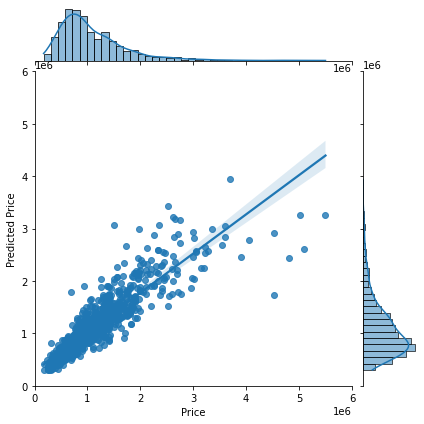

In [38]:
model = best_rf_model

X_train_prepared = rf_full_pipe_final.fit_transform(X_train,y_train)
X_test_prepared  = rf_full_pipe_final.transform(X_test)
# fit the model
model.fit(X_train_prepared, y_train)

# predict training set
y_pred = model.predict(X_test_prepared)

## Evaluate the model and plot it
from sklearn.metrics import mean_squared_error, r2_score
print("----- RANDOM FOREST: EVALUATION ON TEST SET ------")
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE",rmse)
r2=r2_score(y_test, y_pred)
print("R^2: ",r2)

result = pd.DataFrame({"Price":y_test,
                      "Predicted Price":y_pred})

# I prefer this plot.
sns.jointplot(data=result, x="Price", y="Predicted Price",xlim=(0,6000000),ylim=(0,6000000),kind="reg")